# Introduction

---



In this project, we will be studying how the different features of resale flats such as its location and flat model affects its resale price and thus build a model to predict future HDB resale prices with reasonable accuracy.


# Setup

---



Import the libraries needed for our project.




In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.datasets import make_regression
from sklearn import metrics
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
import time
import datetime
import re
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Exploratory Data Analysis (EDA)

---



## Import data

In [ ]:
import os
print(os.listdir())
path = "drive/MyDrive/CS3244Project/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv"
df = pd.read_csv(path)
df.head()

['.config', 'drive', 'sample_data']


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135227 entries, 0 to 135226
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                135227 non-null  object 
 1   town                 135227 non-null  object 
 2   flat_type            135227 non-null  object 
 3   block                135227 non-null  object 
 4   street_name          135227 non-null  object 
 5   storey_range         135227 non-null  object 
 6   floor_area_sqm       135227 non-null  float64
 7   flat_model           135227 non-null  object 
 8   lease_commence_date  135227 non-null  int64  
 9   remaining_lease      135227 non-null  object 
 10  resale_price         135227 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 11.3+ MB


## Explore data

We will use the `find_unique_values` function to look at the unique values within a column to derive some insights on our data.

In [ ]:
# Returns all the unique values within a column (with name col_name) in a df.
# df: DataFrame
# col_name: the name of the column in the df
def find_unique_values(df, col_name):
  return np.unique(np.array(df[col_name]))
  
features = ['month', 'town', 'flat_type', 'storey_range', 'floor_area_sqm', 'flat_model', 'remaining_lease']
categorical_data_features = ['town', 'flat_type', 'storey_range', 'flat_model']
numerical_data_features = ['month', 'remaining_lease']
float_data_features = ['floor_area_sqm']
numerical_data_regex = {'month': r"(\d\d\d\d)", 'remaining_lease': r"(\d\d)" }

for feature in categorical_data_features:
  unique_values_list = find_unique_values(df, feature)
  print("Feature: ", feature, "\n" , unique_values_list, "\n")

Feature:  town 
 ['ANG MO KIO' 'BEDOK' 'BISHAN' 'BUKIT BATOK' 'BUKIT MERAH' 'BUKIT PANJANG'
 'BUKIT TIMAH' 'CENTRAL AREA' 'CHOA CHU KANG' 'CLEMENTI' 'GEYLANG'
 'HOUGANG' 'JURONG EAST' 'JURONG WEST' 'KALLANG/WHAMPOA' 'MARINE PARADE'
 'PASIR RIS' 'PUNGGOL' 'QUEENSTOWN' 'SEMBAWANG' 'SENGKANG' 'SERANGOON'
 'TAMPINES' 'TOA PAYOH' 'WOODLANDS' 'YISHUN'] 

Feature:  flat_type 
 ['1 ROOM' '2 ROOM' '3 ROOM' '4 ROOM' '5 ROOM' 'EXECUTIVE'
 'MULTI-GENERATION'] 

Feature:  storey_range 
 ['01 TO 03' '04 TO 06' '07 TO 09' '10 TO 12' '13 TO 15' '16 TO 18'
 '19 TO 21' '22 TO 24' '25 TO 27' '28 TO 30' '31 TO 33' '34 TO 36'
 '37 TO 39' '40 TO 42' '43 TO 45' '46 TO 48' '49 TO 51'] 

Feature:  flat_model 
 ['2-room' '3Gen' 'Adjoined flat' 'Apartment' 'DBSS' 'Improved'
 'Improved-Maisonette' 'Maisonette' 'Model A' 'Model A-Maisonette'
 'Model A2' 'Multi Generation' 'New Generation' 'Premium Apartment'
 'Premium Apartment Loft' 'Premium Maisonette' 'Simplified' 'Standard'
 'Terrace' 'Type S1' 'Type S2'] 



To take a closer look at each feature's distribution, we plot the following graphs.

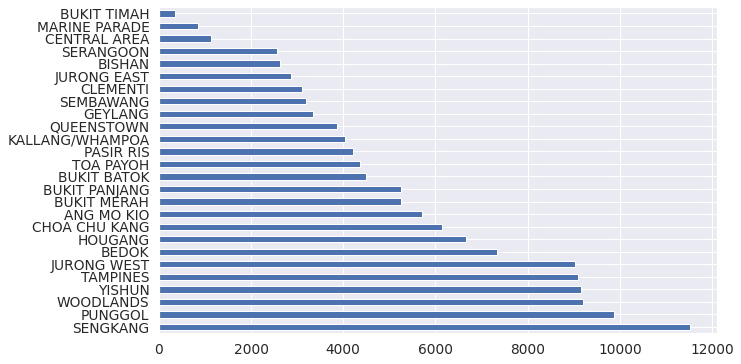

In [ ]:
# Visualizing 'Town'
plt.figure(figsize=(10,6))
fig = df['town'].value_counts().plot(kind='barh')
fig

From the above plot, we can see that Sengkang has the most number of resale HDB flats, followed by Punggol. Punggol and Sengkang are the two most popular towns as there are many relatively new flats under 10 years old, and many of them have recently achieved the five-year minimum occupation period. On the other hand, bukit timah, marine parade and the central area have the least number of HDB flats for resale. 

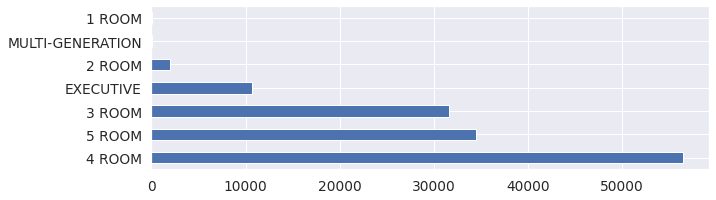

In [ ]:
# Visualizing 'flat_type'
plt.figure(figsize=(10,3))
fig = df['flat_type'].value_counts().plot(kind='barh')
fig

Among the flat types, 4-room flats are the most common as they are ideal for young couples or parents and they are considered as quite spacious for most families.  

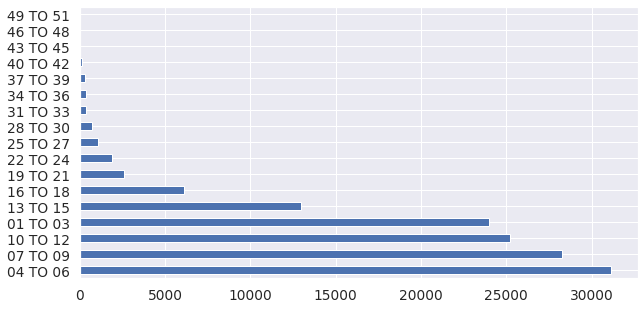

In [ ]:
# Visualizing 'storey_range'
plt.figure(figsize=(10,5))
fig = df['storey_range'].value_counts().plot(kind='barh')
fig

For storey range, floor 4 to 6 is the most popular. This could be due to the higher price for flats on higher storeys, so 4-6 seems to be a moderate storey range. 

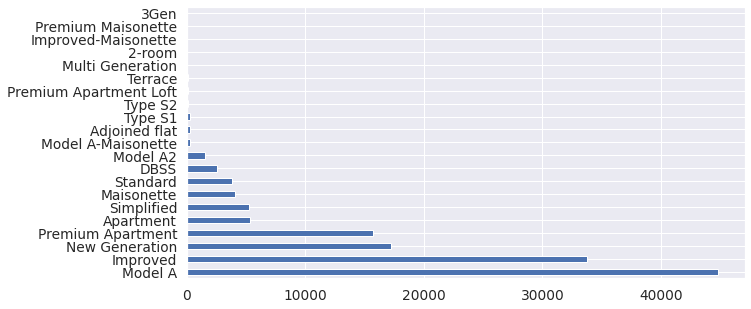

In [ ]:
# Visualizing 'flat_model'
plt.figure(figsize=(10,5))
fig = df['flat_model'].value_counts().plot(kind='barh')
fig

The most popular flat model is Model A. Model A flats are introduced in 1981, and there are 3-Room, 4-Room, 5-Room, 5-Room Maisonette flats, and the floor area ranges from 75 to 139 sqm. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


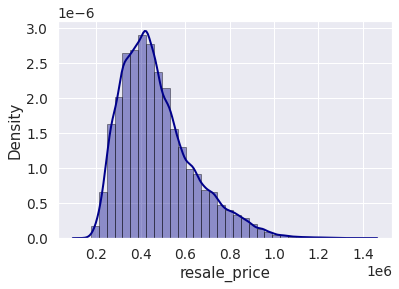

In [ ]:
# Visualizing 'resale_price'
sns.distplot(df['resale_price'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

In [ ]:
# Statistics on resale_price
price_labels = np.array(df['resale_price']).reshape(-1, 1)
price_mean = np.mean(price_labels)
price_max = np.amax(price_labels)
price_min = np.amin(price_labels)
price_std = np.std(price_labels)

print("Mean of price labels", price_mean)
print("Maximum of price labels", price_max)
print("Minimum of price labels", price_min)
print("Standard deviation of price labels", price_std)

Mean of price labels 471383.52256553795
Maximum of price labels 1418000.0
Minimum of price labels 140000.0
Standard deviation of price labels 163249.13638577564


The resale price has a right skewed distribution, with the maximum price being 1.418 million, minimum price being 140 thousands, and a mean resale price of around 471 thousands. 


# Data Preparation

---



## Add in new features

### Estate Maturity

Typically, mature estates are older, more developed and equipped with better public transport infrastructure and they are usually located within or nearer to central region; while non-mature estates are newer, have fewer public transport links and are usually outside of central regions. Due to the differences in accessibility to various amenities, there would be differences in resale prices. We classify each resale flats according their locations and map mature estates to 1 and non-mature estates to 0

In [ ]:
#Explain what is mature/non-mature estates
mature_estates = ['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT MERAH', 'BUKIT TIMAH', 'CENTRAL AREA', 
                  'CLEMENTI', 'GEYLANG','KALLANG/WHAMPOA', 'MARINE PARADE', 'PASIR RIS', 'QUEENSTOWN', 
                  'SERANGOON', 'TAMPINES', 'TOA PAYOH']

non_mature_estates = ['BUKIT BATOK', 'BUKIT PANJANG', 'CHOA CHU KANG', 'HOUGANG', 'JURONG EAST',
                      'JURONG WEST', 'PUNGGOL', 'SEMBAWANG', 'SENGKANG', 'TENGAH', 'WOODLANDS', 
                      'YISHUN']
                      
maturity_list = [non_mature_estates, mature_estates]

maturity_mapper = lambda x: 0 if x in maturity_list[0] else (1 if x in maturity_list[1] else 0.5)
                               

df['estate_maturity'] = df['town'].apply(maturity_mapper)
col_estate = df.pop('estate_maturity')
df.insert(3, 'estate_maturity', col_estate)

### Distance to MRT/Mall/School/CBD

We wish to find out if distance from a HDB flat to its nearby amentities will have an effect on its resale price. Hence, we exactrated the latitude and longitude from the 'block' and 'street_name' column, and then we found the respective distances to the nearest MRT, shopping mall, school as well as the distance to the central business district (CBD).

In [ ]:
flat_lat_lon = pd.read_csv("drive/MyDrive/CS3244Project/finding distances/flat_lat_lon.csv")
df_dist_mrt = pd.read_csv("drive/MyDrive/CS3244Project/finding distances/df_dist_mrt.csv")
df_dist_mall = pd.read_csv("drive/MyDrive/CS3244Project/finding distances/df_dist_mall.csv")
df_dist_cbd = pd.read_csv("drive/MyDrive/CS3244Project/finding distances/df_dist_cbd.csv")
df_dist_sch = pd.read_csv("drive/MyDrive/CS3244Project/finding distances/df_dist_school.csv")

In [ ]:
df['Latitude'] = flat_lat_lon['Latitude']
df['Longitude'] = flat_lat_lon['Longitude']
df['distance_to_mrt'] = df_dist_mrt['distance_to_mrt']
df['distance_to_mall'] = df_dist_mall['distance_to_mall']
df['distance_to_cbd'] = df_dist_cbd['dist_to_cbd'] 
df['distance_to_sch'] = df_dist_sch['distance_to_sch']


## Account for inflation

Considering our data is from 2017 to 2022, we think that inflation is an important factor to consider. As shown by HDB's resale price index, the resale price has been increasing over the years. 

In [ ]:
cpi = pd.read_csv("drive/MyDrive/CS3244Project/df_cpi.csv", index_col=[0])
df['cpi'] = cpi
df['real_price'] = pd.to_numeric((df['resale_price'] / df['cpi']) * 100 )

## Transform features to numerical form

In [ ]:
# Convert month to month, year
df['year'] = pd.DatetimeIndex(df['month']).year
df['month'] = pd.DatetimeIndex(df['month']).month
col = df.pop('year')
df.insert(0, 'year', col)

#Get number of years left on lease as a continuous number (ignoring months) 
mon_col = []
for i in df['remaining_lease']:
  mon_col.append(re.findall(r'\d+', i))
df_lease = pd.DataFrame()
df_lease['mon_col'] = mon_col
df2 = pd.DataFrame(df_lease['mon_col'])
df_lease[['lease_yr','lease_mon']] = pd.DataFrame(df2.mon_col.tolist(), index = df2.index)
df_lease['lease_yr'] = pd.to_numeric(df_lease['lease_yr'])
df_lease['lease_mon'] = pd.to_numeric(df_lease['lease_mon'])
df_lease['lease_mon'][np.isnan(df_lease['lease_mon'])] = 0
df_lease['remaining_lease_year'] = df_lease['lease_yr'] + df_lease['lease_mon']/12
df['remaining_lease'] = df_lease['remaining_lease_year']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
#Get storey range as a continuous number 
storey_range_Dict = {'01 TO 03' : 1, '04 TO 06':2, '07 TO 09':3, '10 TO 12':4, '13 TO 15':5, '16 TO 18':6, '19 TO 21':7, '22 TO 24':8, '25 TO 27':9, '28 TO 30':10, '31 TO 33':11, '34 TO 36':12, '37 TO 39':13, '40 TO 42':14, '43 TO 45':15, '46 TO 48':16, '49 TO 51':17}

# Map flat_type  
flat_type_Dict = {'1 ROOM': 1,'2 ROOM': 2,'3 ROOM': 3,'4 ROOM': 4,'5 ROOM': 5,'EXECUTIVE': 6,'MULTI-GENERATION': 7,}

# Map flat_model 
flat_model_Dict = {'2-room': 1,'3Gen': 2,'Adjoined flat': 3,'Apartment': 4,'DBSS': 5,'Improved': 6,'Improved-Maisonette': 7,'Maisonette': 8,'Model A': 9,'Model A-Maisonette': 10,'Model A2': 11,'Multi Generation': 12,'New Generation': 13,'Premium Apartment': 14,'Premium Apartment Loft': 15,'Premium Maisonette': 16,'Simplified': 17,'Standard': 18,'Terrace': 19,'Type S1': 20,'Type S2': 21}

# North:1, East: 2, West: 3, South: 4, Central:5
townDict = {'ANG MO KIO': 1,'BEDOK': 2,'BISHAN': 1,'BUKIT BATOK': 3,'BUKIT MERAH': 4,'BUKIT PANJANG': 3,'BUKIT TIMAH': 5,'CENTRAL AREA': 5,'CHOA CHU KANG': 3,'CLEMENTI': 3,'GEYLANG': 2,'HOUGANG': 1,'JURONG EAST': 3,'JURONG WEST': 3,'KALLANG/WHAMPOA': 2,'MARINE PARADE': 2,'PASIR RIS': 2,'PUNGGOL': 1,'QUEENSTOWN': 3,'SEMBAWANG': 1,'SENGKANG': 1,'SERANGOON': 5,'TAMPINES': 2,'TOA PAYOH': 5,'WOODLANDS': 1,'YISHUN': 1}

df['storey_range'] = df['storey_range'].replace(storey_range_Dict, regex=True)
df['flat_type'] = df['flat_type'].replace(flat_type_Dict, regex=True)
df['flat_model'] = df['flat_model'].replace(flat_model_Dict, regex=True)
df['town'] = df['town'].replace(townDict, regex=True)

df.head()

,year,month,town,flat_type,estate_maturity,block,street_name,storey_range,floor_area_sqm,flat_model,...,remaining_lease,resale_price,Latitude,Longitude,distance_to_mrt,distance_to_mall,distance_to_cbd,distance_to_sch,cpi,real_price
0,2017,1,1,2,1,406,ANG MO KIO AVE 10,4,44.0,6,...,61.333333,232000.0,1.362005,103.853880,1.000219,0.999942,8.615672,0.227903,133.9,173263.629574
1,2017,1,1,3,1,108,ANG MO KIO AVE 4,1,67.0,13,...,60.583333,250000.0,1.370966,103.838202,1.268446,1.158623,9.715055,0.300984,133.9,186706.497386
2,2017,1,1,3,1,602,ANG MO KIO AVE 5,1,67.0,13,...,62.416667,262000.0,1.380709,103.835368,1.071924,1.933451,10.828736,0.506849,133.9,195668.409261
3,2017,1,1,3,1,465,ANG MO KIO AVE 10,2,68.0,13,...,62.083333,265000.0,1.366201,103.857201,0.945847,0.893796,9.097964,0.518555,133.9,197908.887229
4,2017,1,1,3,1,601,ANG MO KIO AVE 5,1,67.0,13,...,62.416667,265000.0,1.381041,103.835132,1.094825,1.977473,10.869368,0.546443,133.9,197908.887229


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135227 entries, 0 to 135226
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   year                 135227 non-null  int64  
 1   month                135227 non-null  int64  
 2   town                 135227 non-null  int64  
 3   flat_type            135227 non-null  int64  
 4   estate_maturity      135227 non-null  int64  
 5   block                135227 non-null  object 
 6   street_name          135227 non-null  object 
 7   storey_range         135227 non-null  int64  
 8   floor_area_sqm       135227 non-null  float64
 9   flat_model           135227 non-null  int64  
 10  lease_commence_date  135227 non-null  int64  
 11  remaining_lease      135227 non-null  float64
 12  resale_price         135227 non-null  float64
 13  Latitude             135227 non-null  float64
 14  Longitude            135227 non-null  float64
 15  distance_to_mrt  

# Feature Engineering and Selection

## Correlation Matrix

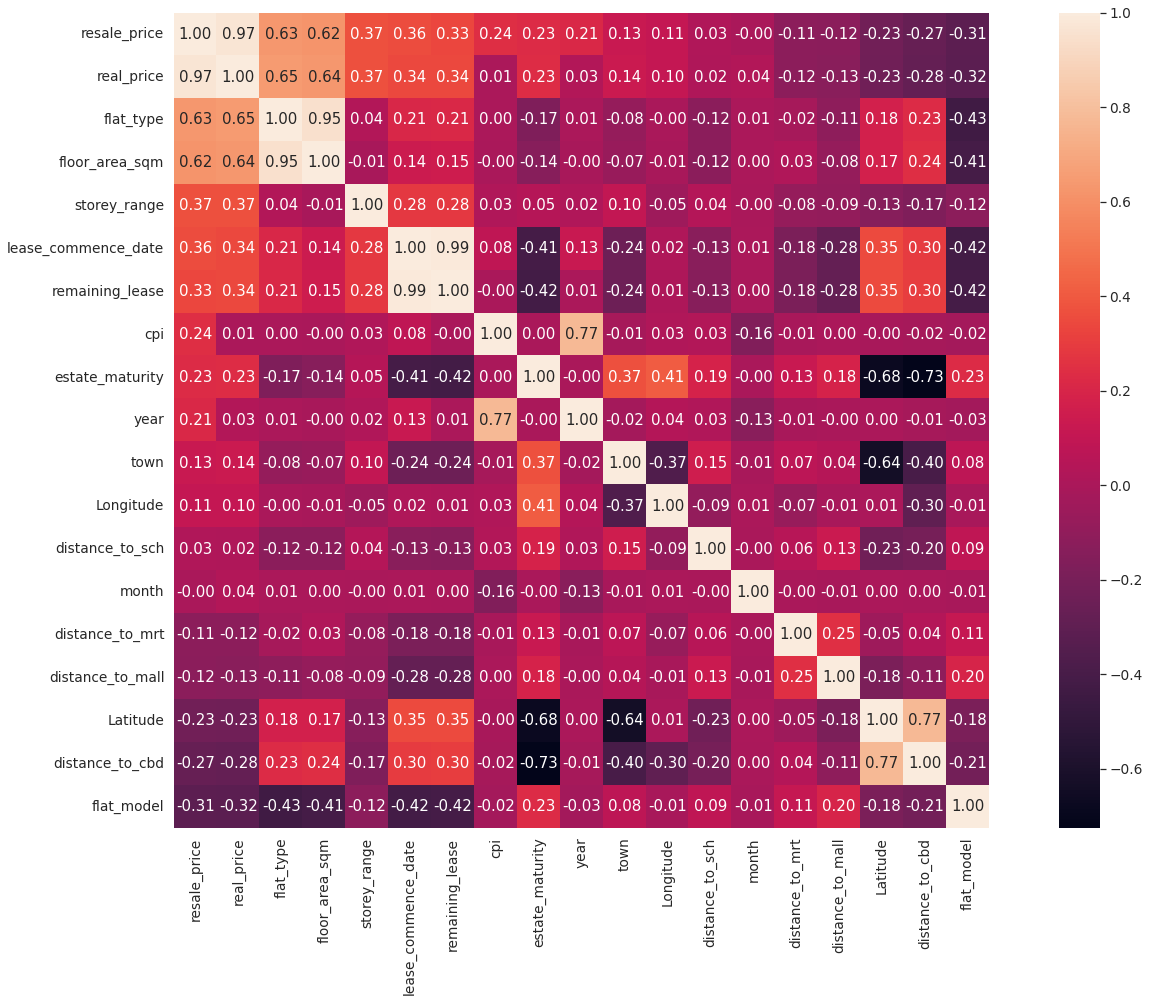

In [ ]:
#resale_price correlation matrix
corrmat = df.corr()
k = 21 #number of variables for heatmap
cols = corrmat.nlargest(k, 'resale_price')['resale_price'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
plt.figure(figsize=(25, 15))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Looking at the correlation matrix, it can be seen that we have 2 pairs of highly correlated features, flat type with floor area sqm and lease commence date with remaining_lease, where correlation is more than 0.9. Thus we decided to remove flat type and lease commence date.


In [ ]:
# dropping features
# flat type and lease commnece date are dropped due to high correlation with floor area sqm and remaining lease respectively
# latitude, longtitude, block, street name are dropped as they are used to feature engineer other features such as distances to an area 
df = df.drop(columns = ['flat_type', 'lease_commence_date', 'Latitude', 'Longitude', 'block', 'street_name'])

Apart from those 2 features, we decided to drop another 4 other features, latitude, longitude, block and street_name. This is becasue individually, they are not really meaningful for analysis and they have already been used to engineer other features in our data set such as distance to CBD.



## Standardizing data

Finally, before training models, we chose to standardize five of the features, floor area sqm, distance to mrt, distance to mall, distance to cbd and distance to school. This is because these are our 5 quantitative features and their range of values vary widely. Through standardization, we change the values of numeric columns to a common scale, without distorting differences in the ranges of values.


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_columns = ['floor_area_sqm', 'distance_to_mrt', 'distance_to_mall', 'distance_to_cbd', 'distance_to_sch']
scaler.fit(df[scaled_columns])
scaled_columns = pd.DataFrame(scaler.transform(df[scaled_columns]), index=df.index, columns=scaled_columns)
unscaled_columns = df.drop(scaled_columns, axis=1)
df = pd.concat([unscaled_columns, scaled_columns], axis=1)

# Training models

## Linear Regression Model

In [ ]:
new_df = df.drop(columns = ['resale_price','real_price'])

In [ ]:
labels = new_df.columns
label_dict = {}

for i in range(len(labels)):
  label_dict[i + 1] = labels[i]
#label_dict

In [ ]:
y = np.array(df['resale_price']).reshape(-1, 1)
X = new_df
training_size = math.floor(0.8 * 135227)

In [ ]:
#Use this if you are doing random split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Use this if you are doing chronological split
X_train = X[0: training_size]
y_train = y[0: training_size]
X_test = X[training_size + 1:]
y_test = y[training_size + 1:]

In [ ]:
# normalising data by training max and min values so as to avoid information leakage
df_max = X_train.max()
df_min = X_train.min()

print(df_max)

X_train = (X_train - df_min) / (df_max - df_min)
X_test = (X_test - df_min) / (df_max - df_min)
X_test

year                2021.000000
month                 12.000000
town                   5.000000
estate_maturity        1.000000
storey_range          17.000000
flat_model            21.000000
remaining_lease       97.750000
cpi                  150.600000
floor_area_sqm         6.277267
distance_to_mrt        7.510147
distance_to_mall       6.346859
distance_to_cbd        1.783695
distance_to_sch       15.941379
dtype: float64


,year,month,town,estate_maturity,storey_range,flat_model,remaining_lease,cpi,floor_area_sqm,distance_to_mrt,distance_to_mall,distance_to_cbd,distance_to_sch
108182,1.00,0.727273,0.0,0.0,0.1250,0.25,0.906396,1.000000,0.366972,0.040647,0.131776,0.706219,0.063826
108183,1.00,0.727273,0.0,0.0,0.0000,0.25,0.926677,1.000000,0.376147,0.030124,0.200389,0.706151,0.078625
108184,1.00,0.727273,0.0,0.0,0.1875,0.25,0.907956,1.000000,0.371560,0.049756,0.147626,0.740849,0.081686
108185,1.00,0.727273,0.0,0.0,0.2500,0.25,0.946958,1.000000,0.371560,0.104957,0.290457,0.683856,0.118807
108186,1.00,0.727273,0.0,0.0,0.1875,0.25,0.946958,1.000000,0.371560,0.104957,0.290457,0.683856,0.118807
...,...,...,...,...,...,...,...,...,...,...,...,...,...
135222,1.25,0.727273,0.0,0.0,0.1250,0.25,0.903276,1.883838,0.376147,0.379194,0.136238,0.735725,0.041409
135223,1.25,0.727273,0.0,0.0,0.0625,0.25,0.371295,1.883838,0.458716,0.254376,0.307969,0.785278,0.068127
135224,1.25,0.727273,0.0,0.0,0.0625,0.25,0.365055,1.883838,0.417431,0.242829,0.304820,0.793200,0.038024
135225,1.25,0.727273,0.0,0.0,0.0000,0.35,0.361934,1.883838,0.527523,0.117913,0.192298,0.743160,0.038327


In [ ]:
# Splitting the data into training and testing data

regr = LinearRegression()
regr.fit(X_train, y_train)
y_pred =  regr.predict(X_test)


print('Regression Score:', regr.score(X_test, y_test))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Regression Score: 0.8155283516943587
Mean Absolute Error: 54391.956566733796
Mean Squared Error: 5204666488.66063
Root Mean Squared Error: 72143.37453058756


In [ ]:
regr.coef_

array([[  17579.5884388 ,    8214.89764333,   21839.94615787,
          70011.07956228,  245964.1328291 ,   45243.10930669,
         245750.40716159,   53828.50806183, 1008609.14020618,
         -95401.32701238,  -24156.68400185, -246805.04729043,
         116207.90980109]])

When we use linear regression, we can see the magnitude and direction of the coefficient of the model to make intepretations about feature importance. 

The top 3 features with highest coefficient is floor_area_sqm followed by distance_to_cbd followed by storey range. These are the top 3 features that are likely to influence the model's prediction of the HDB resale price.

As floor_area_sqm and storey_range's coefficient is positive, this indicates that the model is likely to predict higher resale prices for HDB rooms that are more spacious and at a higher floor.

In constrast, distance_to_cbd coefficient is negative. This indicates that there is an inverse relationship between the distance_to_cbd and the model's prediction of the HDB resale price. In other words, HDBs which are closer to the cbd area are likely to have a higher predicted price.



### SHAP Results

Our group has chosen to use Shapley values to measure the relative feature importance that contribute to the HDB resale price. The idea of the Shapley value is that for one instance, it calculates the value of each features contributions to the prediction of this instance compared to the average prediction of the dataset.






####Bee-Swam Plot

In terms of direction of increase with respect to a change in feature value, we will instead use *bee-swarm* plot to illustrate the relationship between changes in feature value to the change in HDB resale price.

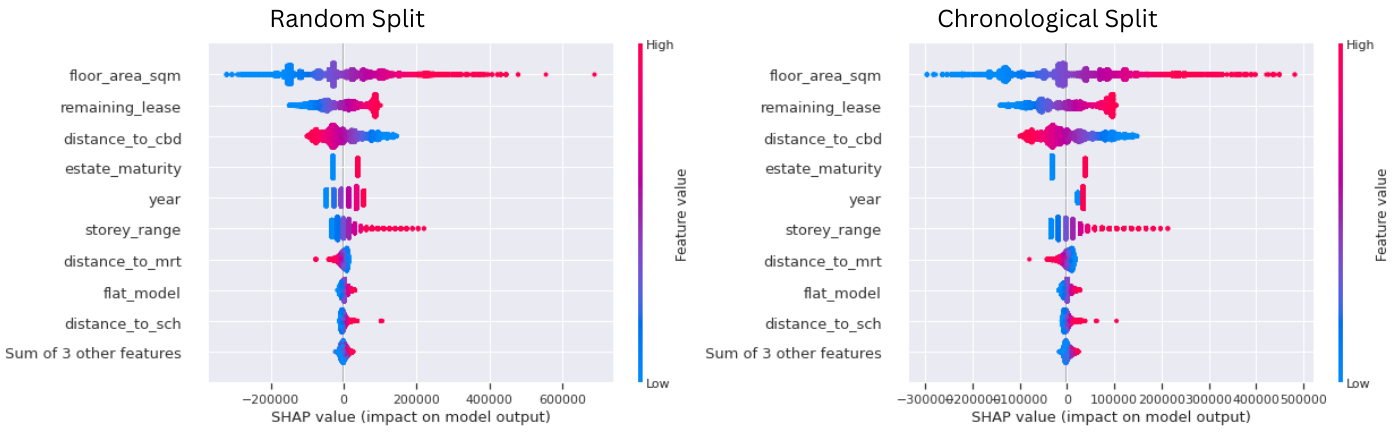

**Analysis of Feature Importance**: 

To answer our project question on which feature affects the HDB resale price the most, we look at the top few features. The plots automatically ranks and put features that have higher relative importance to the top.

From the beeswarm plot, we can see that instances with higher values of floor_area_sqm (denoted by the *red* regions) contributes to an increase in predicted HDB resale price compared to the average prediction of the dataset. Conversely, instances with lower values of floor_area_sqm (denoted by the *blue* regions) contributes to a decrease in predicted HDB resale price compared to the average prediction of the dataset. 

Using similar analysiss to other features, we see that using linear regression as the model, the top 2 features with the highest feature importance that leads to an *increase* in HDB resale price is

1. floor_area_sqm
1. remaining_lease

Meanwhile, the top 2 features with the highest feature importance that leads to a *decrease* in HDB resale price is

1. distance_to_cbd
1. distance_to_mrt

####Bar Chart Plot

To illustrate the magnitude of each feature’s Shapley value, we will use a *bar chart* for visualisation.

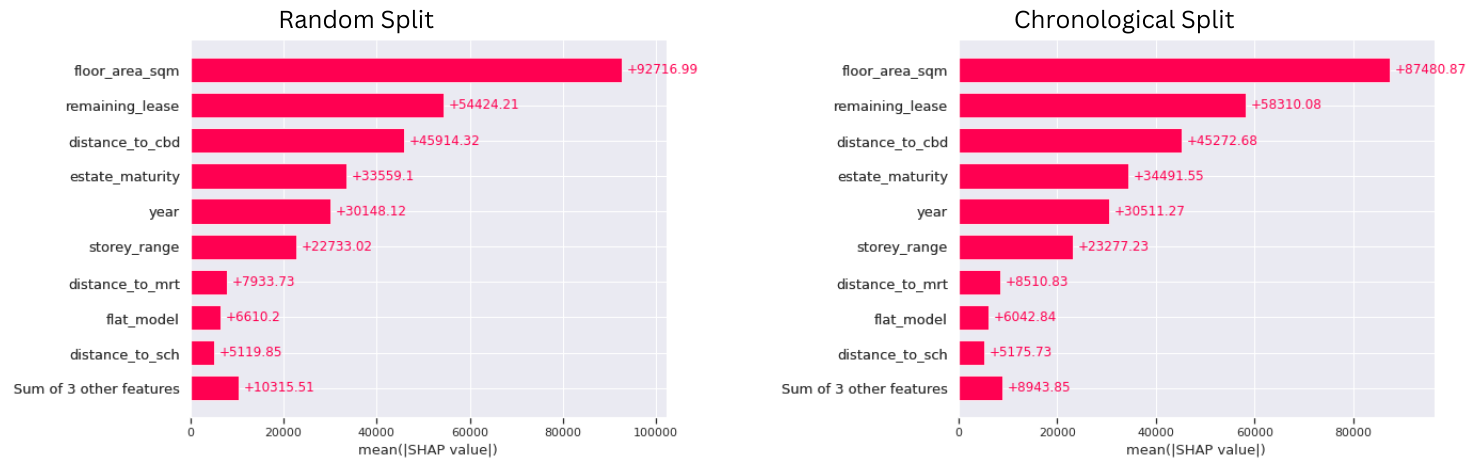

**Analysis of Feature Importance**: 

To answer our project question on which feature affects the HDB resale price the most, we look at the top few features. The plots automatically ranks and put features that have higher relative importance to the top.

From the bar chart plot, we can see that the feature with highest importance is the floor_area_sqm that contributes an average of S$92716 (if random split) to the prediction of the HDB resale price compared to the average prediction of the dataset.

Using similar analysiss to other features, we see that using linear regression as the model, the top 3 features with the highest feature importance that leads to a change in HDB resale price is

1. floor_area_sqm
1. remaining_lease
1. distance_to_cbd


#### Analysis of Chronological vs Random Split

**Analysis of Chronological vs Random Split**:

We experimented with the concept of extrapolation and interpolation by changing how we split the train and test set.

Random split is using `train_test_split` while the chronological split divides the data such that the training data is *earlier* than the testing data.

The ranking of the feature importance does not change with linear regression. Contribution of each feature has a similar distribution.

## Random Forest Model

In [ ]:
regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Mean Absolute Error: 48671.728509903885
Mean Squared Error: 3861682125.529923
Root Mean Squared Error: 62142.43417770117


### SHAP Results

Differing from linear regression, due to the long running time of SHAP on random forest, we have decided to randomly sample *half* of the test data for the model to explain. This will help us speed up the computation time at the cost of increased variance of Shapley values.

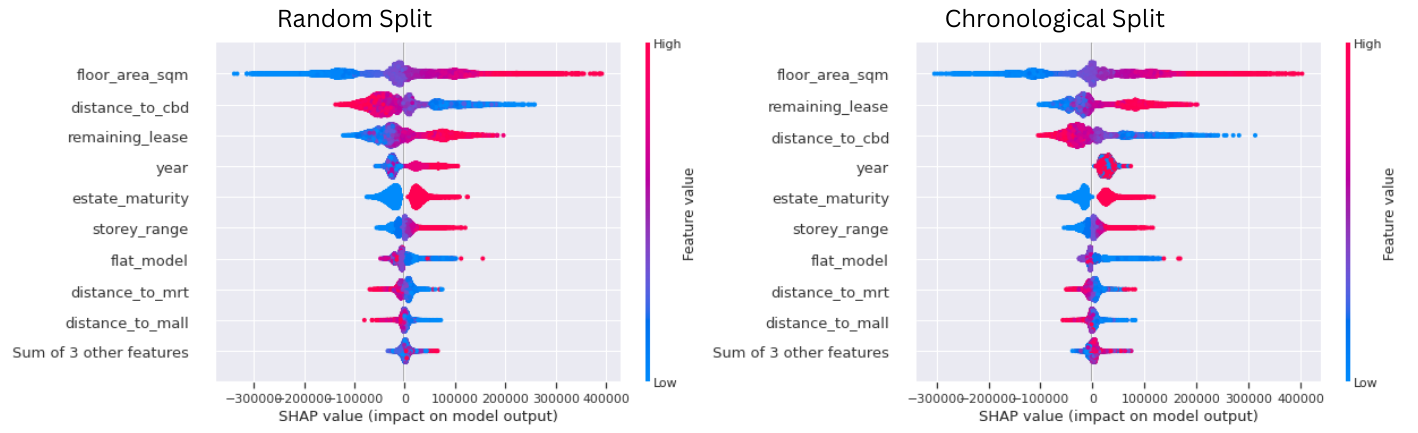

**Analysis of Feature Importance**: 

To answer our project question on which feature affects the HDB resale price the most, we look at the top few features. The plots automatically ranks and put features that have higher relative importance to the top.

From the beeswarm plot, we can see that instances with higher values of floor_area_sqm (denoted by the *red* regions) contributes to an increase in predicted HDB resale price compared to the average prediction of the dataset. Conversely, instances with lower values of floor_area_sqm (denoted by the *blue* regions) contributes to a decrease in predicted HDB resale price compared to the average prediction of the dataset. 

Using similar analysiss to other features, we see that using random forest as the model, the top 2 features with the highest feature importance that leads to an *increase* in HDB resale price is

1. floor_area_sqm
1. remaining_lease

Meanwhile, the top 2 features with the highest feature importance that leads to a *decrease* in HDB resale price is

1. distance_to_cbd
1. flat_model


**Analysis of Results (Linear Regression Vs Random Forest)**

An interesting observation we can look from the beeswarm plot of both linear regression and random forest is that linear regression is more smooth and has a smooth spectrum from blue to red or from red to blue. 

For example,  if we look at *distance_to_cbd* feature, we can see a very gradual change in colour from red to purple to blue in linear regression's beeswarm. This means that shapley value for *distance_to_cbd* increases as the *distance_to_cbd* feature value decreases.

However, in the random forest beeswarm, we can see a few smattering of blue/purple feature values in the red region of *distance_to_cbd* features.

This difference could likely be due to how linear regression determines the decision boundary compared to random forest. Linear regression uses a hyperplane and thus it produces the gradual change in feature values we see in the linear regression beeswarm. Meanwhile, random forest like decision tree uses axis perpendicular decision boundary and thus the feature values may not have as gradual change as that of the linear regression beeswarm plot.

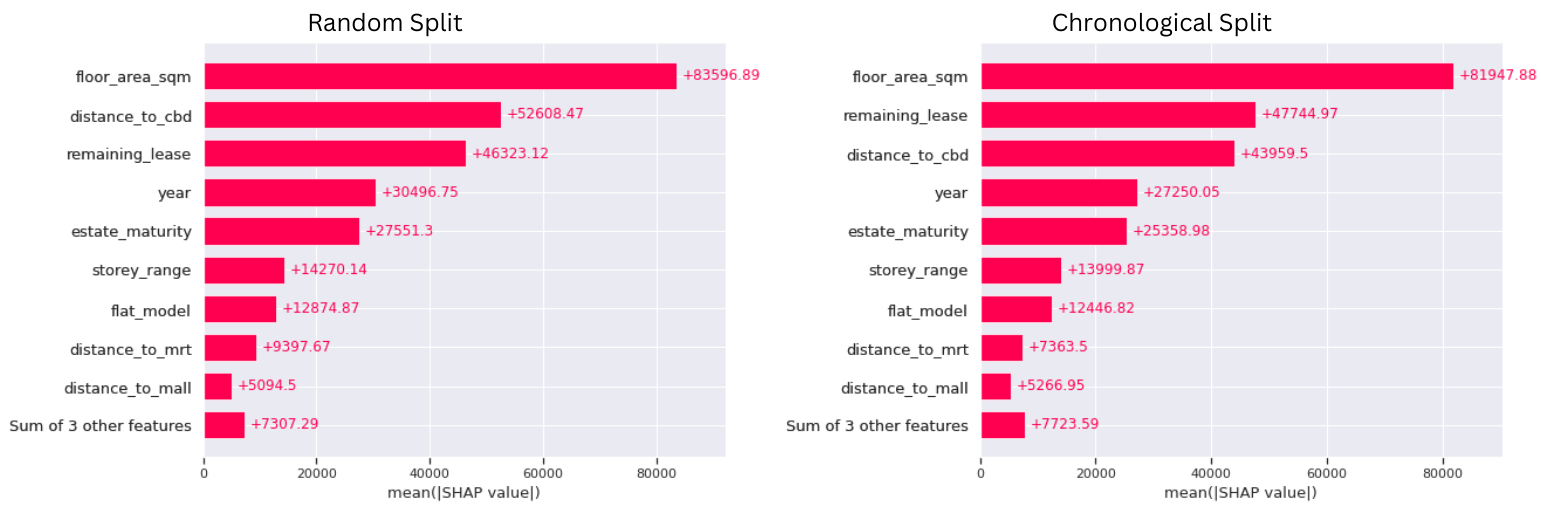

**Analysis of Feature Importance**: 

To answer our project question on which feature affects the HDB resale price the most, we look at the top few features. The plots automatically ranks and put features that have higher relative importance to the top.

From the bar chart plot, we can see that the feature with highest importance is the floor_area_sqm that contributes an average of S$83596 (if random) to the prediction of the HDB resale price compared to the average prediction of the dataset.

Using similar analysiss to other features, we see that using random forest as the model, the top 3 features with the highest feature importance that leads to a change in HDB resale price if we do *random* split is

1. floor_area_sqm
1. distance_to_cbd
1. remaining_lease

Using similar analysiss to other features, we see that using random forest as the model, the top 3 features with the highest feature importance that leads to a change in HDB resale price if we do *chronological* split is

1. floor_area_sqm
1. remaining_lease
1. distance_to_cbd

## K Nearest Neighbour(KNN) Model

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(algorithm='brute')
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 54326.70701837679
Mean Squared Error: 5544966519.246258
Root Mean Squared Error: 74464.53195479212


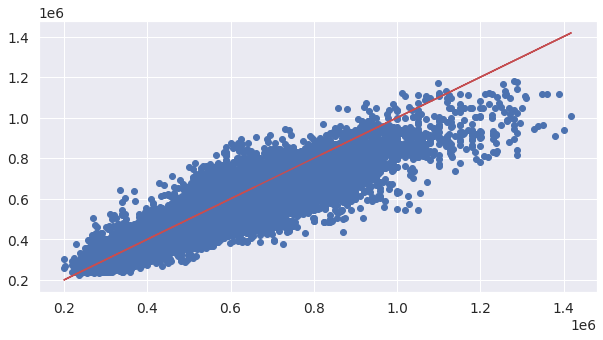

In [ ]:
# Visualizing Our predictions
fig = plt.figure(figsize=(10,5))
plt.scatter(y_test,y_pred)
# Perfect predictions
plt.plot(y_test,y_test,'r')

In [ ]:
df1 = pd.DataFrame([{'Actual': y_test, 'Predicted': y_pred}])
df2 = np.array(df1['Actual']).reshape(-1, 1)
df2

array([[array([[660000.],
               [595000.],
               [650000.],
               ...,
               [532000.],
               [798000.],
               [818000.]])]], dtype=object)

# Social Implications of Model

We will consider the impact on buyers and sellers, since they are our target audience of our machine learning model.

One of the concerns about using random forest as our chosen model is that it cannot discover trends via extrapolation in the long run. Thus, one such feature that does not have its full range of values is the *remaining_lease*. Since the lease for HDB is 99 years, we know that the remaining lease can span from 0 to 99 years. Meanwhile, the minimum remaining_lease of our data is 43 years. Since random forest is not good at extrapolating, it can lead to an inaccurate prediction of HDB resale price.

If the HDB resale price for flats with lower remaining_lease in the future is predicted lower than actual price, buyers will gain our while sellers will lose out.

Similarly, an incorrect prediction of a higher HDB resale price that the true value will be the sellers gain and buyers' loss.

Secondly, if we look at our model, both our linear regression and random forest models has floor_area_sqm as the feature with the highest importance. Again, because our training data does not have the full range of remaining_lease, our model may not be able to successfully predict the effects of values of remaining_lease outside the training data range on the HDB resale price. The effect on the price as the HDB nears the end of its lease could very well be more impactful than the floor_area_sqm since the buyers will not get to keep the flat for that long. 

As such, this limitation may cause future sales of old 5 room models with very little remaining lease to be priced higher than it should be. Buyers who do not do their due diligence may overpay for these HDB resale flats. Meanwhile, sellers who use this pricing may not get a buyer because the low remaining_lease of the HDB flat makes it not a worthwhile purchase.

To highlight the effect to our second point, evidence points to a rise in demand for larger flats due to a rise in hybrid working mode. As such, our models limitations in extrapolating effects of *remaining_lease* on HDB resale price is much more pronounced.

According to a Channelnewsasia article (Tang, 2022), they mention that Covid has led to a rise in hybrid working mode and hence there is a greater demand for bigger flats since more people are working from home. Furthe, the number of five room flats Build-To-Order (BTOs) flat has been much lower especially in mature estate, leading for demand of BTOs 

Additionally, our model will bound to be outdated and inaccurate in the future as there is a constant sale of HDB flats and there is always new data. Our model only uses resale flats up till September 2022(TBC), and this may lead to inaccurate predictions of future flats as the feature importance might change in future resale flats.

# Limitations


Measuring distance from HDB flat to nearest MRT, School and CBD using euclidean distance of latitude and longitute may not be accurate. As the actual distances is longer due to other buildings and roads in between. This can be improved on with the help of google map's api to compute travelling time instead.

There are also other unpredictable factors that might have affect the sale of HDB flats. One factor is future development plans in Singapore. Any areas that the Singapore Government has plans to develop will like lead to HDB near the region to increase, as show in this article https://scholarbank.nus.edu.sg/handle/10635/221696. Whereby, the HDB near the Jurong Lake District had their values increase after the annoucement of the development projects in that area. 

In addition, there could be some anamoly factors such as unnatural death incident in the flat, presence of ghost stories and buyer/sellers urgent needs that can led to drastic changes in resale price.

Lastly, there are also factors that are very hard to measured and implemented, such as the conditions of the flat when it sold. A flat that is renovated nicely and does not have any existing damgages is likely to fetch a higher price compared to a flat that is in a bad condition. This can be measured by the total rennovation fees after the purchase of the flat. However, it is infeasible as it may differ from person to person and very difficult to obtain.

# Annex 

In this section, these are our codes to preprocess the data such as calling the API to find the distance to MRT. The code here is for your reference and is not needed to run since we have the data in our CSV.

Meanwhile, the code to run SHAP explainer will take quite a few hours especially for random forest, so it is advised not to run this section of the code unless its for checking purposes.

## Code for finding the distances

### Finding Latitude and Longitude of flat

In [ ]:
df['address'] = df['block'].map(str) + ' ' + df['street_name'].map(str)
list_all = list(df['address'])
addresslist = list_all

# function for geocoding
def getcoordinates(address):
    req = requests.get('https://developers.onemap.sg/commonapi/search?searchVal='+address+'&returnGeom=Y&getAddrDetails=Y&pageNum=1')
    rdict = eval(req.text)
    if len(rdict['res'])>0:
        return rdict['res'][0]['LATITUDE'], rdict['res'][0]['LONGITUDE']
    else:
        pass

coordlist= []
count = 0
for add in addresslist:
    try:
        if len(getcoordinates(add))>0:
            count += 1
            coordlist.append(getcoordinates(add))
    except:
        count += 1
        coordlist.append(None)

## combine the df
df_coordinates = pd.DataFrame(coordlist)
df_combined = df.join(df_coordinates)
df_combined  = df_combined .rename(columns={0:'Latitude', 1:'Longitude'})
df_combined.to_csv('flat_lat_lon.csv')
!cp flat_lat_lon.csv "drive/MyDrive/CS3244Project"


KeyError: ignored

### Distance to MRT

In [ ]:
from geopy.distance import geodesic
df_mrt = pd.read_csv("drive/MyDrive/CS3244Project/mrtsg.csv")
def find_dist(df_1, df_mrt):
  lat, lon = df_1[['Latitude','Longitude']]
  min_dist = 9999.0
  for mrt_lat, mrt_lon in zip(df_mrt['Latitude'], df_mrt['Longitude']):
    dist = geodesic((lat, lon), (mrt_lat, mrt_lon)).km
    if dist < min_dist:
      min_dist = dist
  return min_dist
dist_series = df_combined.apply(find_dist, axis=1, df_mrt=df_mrt)
df_combined['distance_to_mrt'] = dist_series
df_1 = df_combined['distance_to_mrt']

df_1.to_csv('df_dist_mrt.csv')
!cp df_dist_mrt.csv "drive/MyDrive/CS3244Project"

### Distance to mall

In [ ]:
df_1 = pd.read_csv("drive/MyDrive/CS3244Project/flat_lat_lon.csv")
df_1 = df_1.iloc[:,-2:]
from geopy.distance import geodesic
df_mall = pd.read_csv("drive/MyDrive/CS3244Project/mall_coordinates_updated.csv")
def find_dist(df_1, df_mall):
  lat, lon = df_1[['Latitude','Longitude']]
  min_dist = 9999.0
  for mall_lat, mall_lon in zip(df_mall['latitude'], df_mall['longitude']):
    dist = geodesic((lat, lon), (mall_lat, mall_lon)).km
    if dist < min_dist:
      min_dist = distance
  return min_dist
dist_series = df_combined.apply(find_dist, axis=1, df_mall=df_mall)
df_combined['distance_to_mall'] = dist_series
df_2 = df_combined['distance_to_mall']

df_2.to_csv('df_dist_mall.csv')
!cp df_dist_mall.csv "drive/MyDrive/CS3244Project"

### Distance to CBD


We use the Raffles Place MRT station's coordinates as a reference, to estimate the distance from each HDB flat to the CBD. 

In [ ]:
from geopy.distance import geodesic
df_1 = pd.read_csv("drive/MyDrive/CS3244Project/flat_lat_lon.csv")
df_2 = df_1.iloc[:,-2:]
distance=[]
def find_dist(df_2):
  for lat, lon in zip(df_2['Latitude'], df_2['Longitude']):
    #print(geodesic((lat, lon), (1.284125611, 103.8514572)).km)
    distance.append(geodesic((lat, lon), (1.284125611, 103.8514572)).km)
  return distance
dist_to_cbd = find_dist(df_2)
df_dist_cbd = pd.DataFrame(dist_to_cbd, columns = ['dist_to_cbd'])

df_dist_cbd.to_csv('df_dist_cbd.csv')
!cp df_dist_cbd.csv "drive/MyDrive/CS3244Project"

### Distance to school

In [ ]:
from geopy.distance import geodesic
df_1 = pd.read_csv("drive/MyDrive/CS3244Project/flat_lat_lon.csv")
df_1 = df_1.iloc[:,-2:]
df_school = pd.read_csv("drive/MyDrive/CS3244Project/school_coordinates.csv")
def find_dist(df_1, df_school):
  lat, lon = df_1[['Latitude','Longitude']]
  min_dist = 9999.0
  for sch_lat, sch_lon in zip(df_school['latitude'], df_school['longitude']):
    distance = geodesic((lat, lon), (sch_lat, sch_lon)).km
    if distance < min_dist:
      min_dist = distance
  return min_dist
dist_series = df_1.apply(find_dist, axis=1, df_school=df_school)
df_1['distance_to_sch'] = dist_series
df_2 = df_1['distance_to_sch']
df_2.to_csv('df_dist_school.csv')
!cp df_dist_school.csv "drive/MyDrive/CS3244Project"

## Code for SHAP

In [ ]:
!pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 37.1 MB/s 


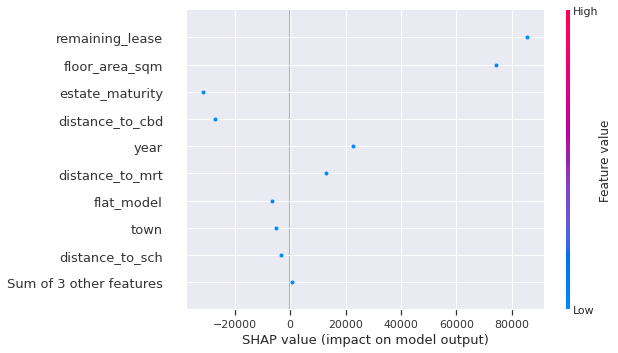

In [ ]:
model2 = LinearRegression()
model2.fit(X_train, y_train)
masker2 = shap.maskers.Independent(data=X_train)

explainer2 = shap.Explainer(
    model2.predict, masker=masker2, feature_names=X_test.columns, algorithm="auto")
shap_values2 = explainer2(X_test)

# plotting of data
shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values[0], feature_names = explainer.data_feature_names)
fig = shap.plots.bar(shap_values2, show=False)
plt.savefig('drive/MyDrive/CS3244Project/LinearRegressionShapBar_random.png')
plt.clf()
fig2 = shap.plots.beeswarm(shap_values2, show=False)
plt.savefig('drive/MyDrive/CS3244Project/LinearRegressionBeeSwarm_random.png')


In [ ]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
masker = shap.maskers.Independent(data=X_train)

explainer = shap.Explainer(
    model.predict, masker=masker, feature_names=X_test.columns, algorithm="auto")
shap_values = explainer(X_test.sample(frac = 0.5))

# plotting of data
shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values[0], feature_names = explainer.data_feature_names)
fig = shap.plots.bar(shap_values, show=False)
plt.savefig('drive/MyDrive/CS3244Project/RandomForestShapBar_random.png')
plt.clf()
fig2 = shap.plots.beeswarm(shap_values, show=False)
plt.savefig('drive/MyDrive/CS3244Project/RandomForestBeeSwarm_random.png')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
Permutation explainer:   3%|▎         | 455/13522 [03:58<1:57:25,  1.85it/s]


KeyboardInterrupt: ignored

# Reference 





SHAP Details: 

https://christophm.github.io/interpretable-ml-book/shap.html

SHAP data visualisation (beeswarm, bar chart): 

https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137#:~:text=SHAP%20values%20

Reasons as to why HDB prices rise in recent years: 

https://www.channelnewsasia.com/singapore/hdb-resale-prices-every-singapore-town-current-property-boom-3043466

Evidence for how future development plans increase resale prices

https://scholarbank.nus.edu.sg/handle/10635/221696

Singapore estate maturity:

https://www.99.co/singapore/insider/what-is-non-mature-estates-vs-mature-estates-hdb/

Singapore District Guide:

https://sharonanngoh.com/useful-info/singapore-district-guide/

Geocoding Singapore Coordinates: OneMap API

https://towardsdatascience.com/geocoding-singapore-coordinates-onemap-api-3e1542bf26f7

Location of shopping malls:

https://github.com/ValaryLim/Mall-Coordinates-Web-Scraper/blob/master/mall_coordinates_updated.csv

Location of MRT stations:

https://github.com/hxchua/datadoubleconfirm/blob/master/datasets/mrtsg.csv

Location of Schools:

https://www.kaggle.com/datasets/subhamjain/schools-information-directory-singapore?resource=download

HDB resale price index:

https://tablebuilder.singstat.gov.sg/table/TS/M212161
